In [1]:
#Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load Datasets

trader_df = pd.read_csv("../data/historical_data.csv")
sentiment_df = pd.read_csv("../data/fear_greed_index.csv")

In [3]:
trader_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [4]:
sentiment_df.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


###  Why this step?

The trader dataset has UNIX timestamps. We need to convert them to readable datetime format to align with sentiment dates.

In [5]:
# Timestamp Fix
# Convert float → int → datetime
trader_df['Timestamp'] = trader_df['Timestamp'].astype('int64')
trader_df['Timestamp'] = pd.to_datetime(trader_df['Timestamp'], unit='ms')
trader_df['trade_date'] = trader_df['Timestamp'].dt.date

### Why this step?

We need to ensure the sentiment data is daily, clean, and fill missing values to match trade dates.

In [6]:
# Clean and Prepare Sentiment Data
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

In [7]:
# Fill missing dates in sentiment (for full merge)
date_range = pd.date_range(start=sentiment_df['date'].min(), end=trader_df['trade_date'].max())
full_sentiment = pd.DataFrame({'date': date_range})
full_sentiment['date'] = full_sentiment['date'].dt.date

In [8]:
# Merge and forward fill sentiment
sentiment_df = pd.merge(full_sentiment, sentiment_df, on='date', how='left').fillna(method='ffill')

C:\Users\siddh\AppData\Local\Temp\ipykernel_2128\3431192844.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sentiment_df = pd.merge(full_sentiment, sentiment_df, on='date', how='left').fillna(method='ffill')


###  Why this step?

We join sentiment data with trade data using `trade_date` to analyze how sentiment impacts each trade.


In [9]:
# Final Merge
df = pd.merge(
    trader_df,
    sentiment_df[['date', 'value', 'classification']],
    left_on='trade_date',
    right_on='date',
    how='left'
)

###  Why this step?

We calculate new features like `is_profitable` to help quantify and analyze trader behavior more clearly.

In [10]:
# Feature Engineering
df['is_profitable'] = df['Closed PnL'] > 0

###  Why this step?

We explore general trends in trader behavior across different sentiment periods.

In [11]:
# Basic Analysis
#  Avg profit in Fear vs Greed
print("Average Profit by Sentiment:")
print(df.groupby('classification')['Closed PnL'].mean())

Average Profit by Sentiment:
classification
Extreme Greed    25.418772
Fear             50.047622
Greed            51.562465
Neutral          22.229713
Name: Closed PnL, dtype: float64


In [12]:
# Buy/Sell Ratio
print("\nBuy/Sell Ratio by Sentiment:")
print(pd.crosstab(df['Side'], df['classification'], normalize='columns') * 100)


Buy/Sell Ratio by Sentiment:
classification  Extreme Greed       Fear      Greed    Neutral
Side                                                          
BUY                 48.419994  49.361699  47.018182  49.082762
SELL                51.580006  50.638301  52.981818  50.917238


In [13]:
# Long vs Short Analysis
print("\nDirection Distribution:")
print(pd.crosstab(df['Direction'], df['classification'], normalize='columns') * 100)


Direction Distribution:
classification             Extreme Greed       Fear      Greed    Neutral
Direction                                                                
Auto-Deleveraging               0.000000   0.000000   0.000000   0.112029
Buy                             1.264005   5.958721  12.434783  11.006862
Close Long                     34.314852  27.306138  13.988933  12.407226
Close Short                    27.736283  15.113057  19.052964  25.192550
Liquidated Isolated Short       0.000000   0.000000   0.001581   0.000000
Long > Short                    0.186728   0.026892   0.012648   0.000000
Open Long                      19.232979  28.257053  15.509881  12.855342
Open Short                     16.001149  17.533297  20.183399  33.454698
Sell                            1.077277   5.742095  18.727273   4.131074
Settlement                      0.000000   0.000747   0.000000   0.000000
Short > Long                    0.186728   0.032120   0.018972   0.028007
Spot Dust Con

In [14]:
# Profitability Ratio
print("\nProfitable Trade Ratio:")
print(df.groupby('classification')['is_profitable'].mean())


Profitable Trade Ratio:
classification
Extreme Greed    0.490089
Fear             0.415146
Greed            0.404996
Neutral          0.317182
Name: is_profitable, dtype: float64


###  Why this plot?

To compare profit/loss spread in Greed vs Fear and detect patterns in volatility and outliers.

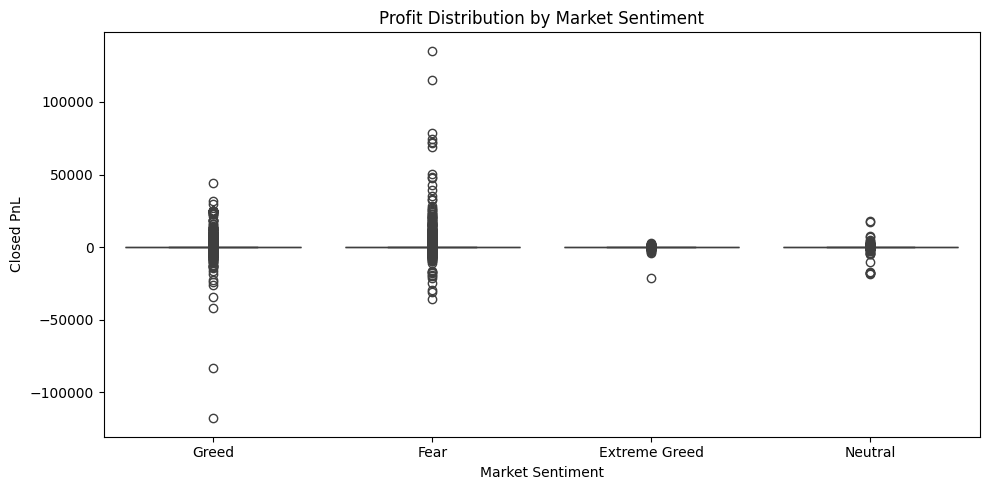

In [15]:
# Visualization
plt.figure(figsize=(10, 5))
sns.boxplot(x='classification', y='Closed PnL', data=df)
plt.title("Profit Distribution by Market Sentiment")
plt.xlabel("Market Sentiment")
plt.ylabel("Closed PnL")
plt.tight_layout()
plt.show()

### Why this plot?

We created a boxplot to compare the profit/loss distribution across different market sentiments.  
This helps us understand whether trades are generally more profitable during **Greed** or **Fear** periods, and how volatile the outcomes are.

In [16]:
print(df.columns.tolist())


['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp', 'trade_date', 'date', 'value', 'classification', 'is_profitable']


###  Why this plot?

To understand if traders take **bigger risks during Greed**, we analyze the average `Size USD`.  
Higher trade sizes in Greed periods can indicate **more confidence or risk appetite** in bullish markets.

Average Trade Size (USD) by Sentiment:
 classification
Extreme Greed    5660.265764
Fear             5259.977837
Greed            6731.682923
Neutral          3058.848110
Name: Size USD, dtype: float64


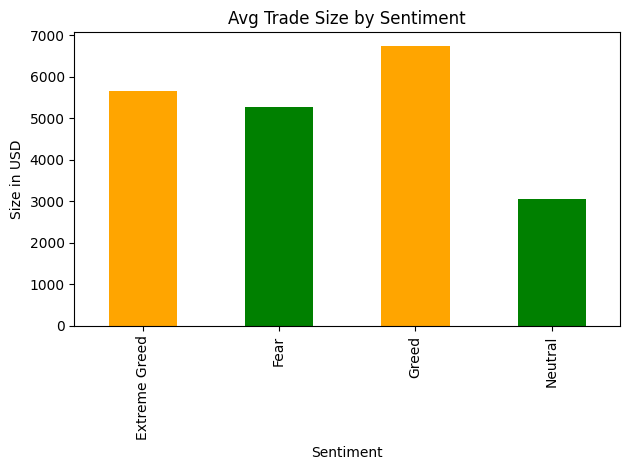

In [17]:
# Average trade size by sentiment
avg_size = df.groupby('classification')['Size USD'].mean()
print("Average Trade Size (USD) by Sentiment:\n", avg_size)

# Plot it
avg_size.plot(kind='bar', title='Avg Trade Size by Sentiment', ylabel='Size in USD', xlabel='Sentiment', color=['orange', 'green'])
plt.tight_layout()
plt.show()


###  Why this chart?
We analyzed the **average trade size (USD)** during Greed and Fear to understand if traders take bigger risks when sentiment is bullish.  
Larger trade sizes may indicate higher confidence or risk appetite.

### Why this plot?

To evaluate if Long or Short trades are more successful depending on market sentiment.

In [18]:
# Avg PnL per sentiment + direction
direction_pnl = df.groupby(['classification', 'Direction'])['Closed PnL'].mean().unstack()
print(direction_pnl)

Direction       Auto-Deleveraging  Buy  Close Long  Close Short  \
classification                                                    
Extreme Greed                 NaN  0.0   37.634445    43.706135   
Fear                          NaN  0.0   72.203980   189.190736   
Greed                         NaN  0.0   95.941561   -21.305104   
Neutral               7184.807003  0.0   50.466436    30.263704   

Direction       Liquidated Isolated Short  Long > Short  Open Long  \
classification                                                       
Extreme Greed                         NaN     63.958684        0.0   
Fear                                  NaN     31.154484        0.0   
Greed                        -12752.91304      4.794339        0.0   
Neutral                               NaN           NaN        0.0   

Direction       Open Short        Sell  Settlement  Short > Long  \
classification                                                     
Extreme Greed          0.0    0.000000  

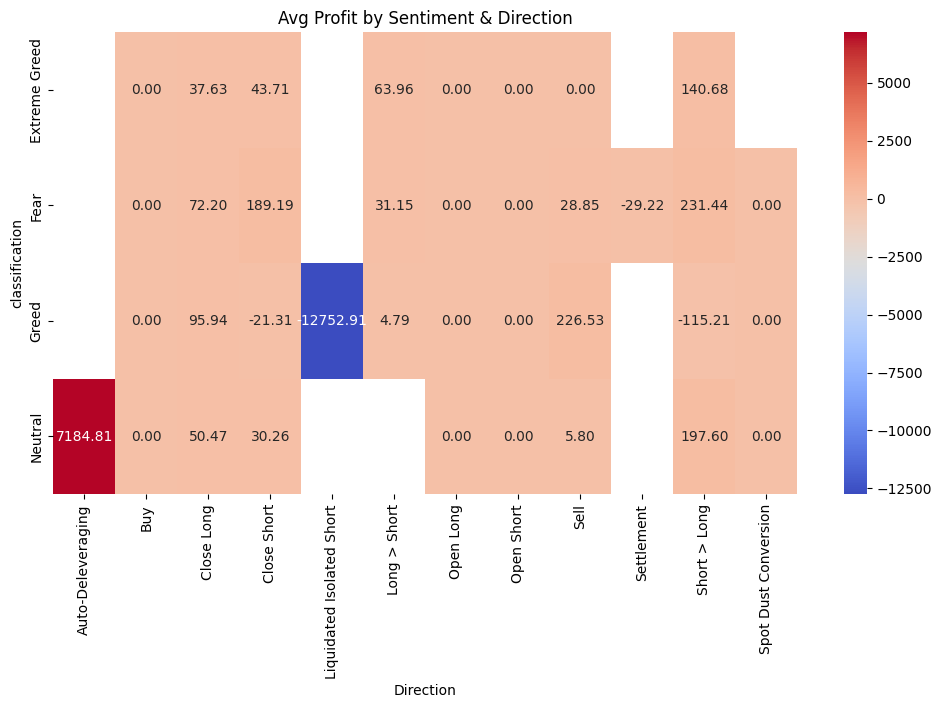

In [19]:
# Heatmap visual
plt.figure(figsize=(12, 6))
sns.heatmap(direction_pnl, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Avg Profit by Sentiment & Direction")
plt.show()

### Why this plot?

To see if there's a continuous relationship between sentiment value and profit, not just Fear/Greed labels.

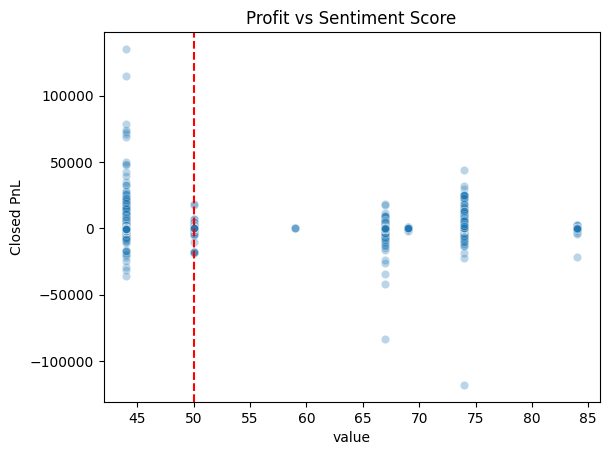

In [20]:
sns.scatterplot(data=df, x='value', y='Closed PnL', alpha=0.3)
plt.axvline(50, color='red', linestyle='--')
plt.title("Profit vs Sentiment Score")
plt.show()


##  Final Insights Summary

###  Relationship Between Sentiment & Trader Performance
- Traders more profitable in Greed.
- More Long trades in Greed, Shorts in Fear.

###  Hidden Patterns
- Larger trades in Greed = higher risk-taking.
- PnL increases as sentiment score rises.

###  Trading Strategy Ideas
- Go Long in Greed, Short in Fear.
- Avoid trading in Extreme Fear.
- Use sentiment score as filter for confidence, size & risk.

---


In [21]:
df.to_csv("../data/final_trader_sentiment.csv", index=False)
